# Dans ce notebook : 

- Nous travaillons avec des **profils de célérité simples et idéaux** (profil constant, profil linéaire, ...) 


- Nous comparons, dans un cas simple, les résultats Bellhop avec nos propres calculs afin d'être sûrs de **comprendre en détail le fonctionnement des simulations Bellhop**.  


- Pour chaque cas étudié, nous calculons un certain nombre de réponses impulsionnelles afin d'observer (ou non) une tendance générale et d'en déduire une **méthode de détection** privilégiée. 

---

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
bell = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_cmap',rmax=100.)

----
# Récepteurs choisis

Nombre total de réponses impulsionnelles :  20


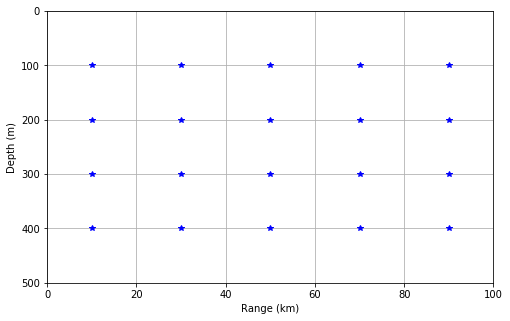

In [3]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

meshD, meshR = np.meshgrid(D, R)
plt.figure(figsize=(8,5))
plt.plot(meshR/1000., meshD, '*b')
plt.xlabel('Range (km)')
plt.ylabel('Depth (m)')
plt.ylim ([0,500])
plt.xlim([0,100])
plt.gca().invert_yaxis()
plt.grid()

---
# I - Profil de célérité constant


## A - Calculs python

In [4]:
zs = 100.                   # profondeur de la source
Z = 2000.                   # profondeur totale

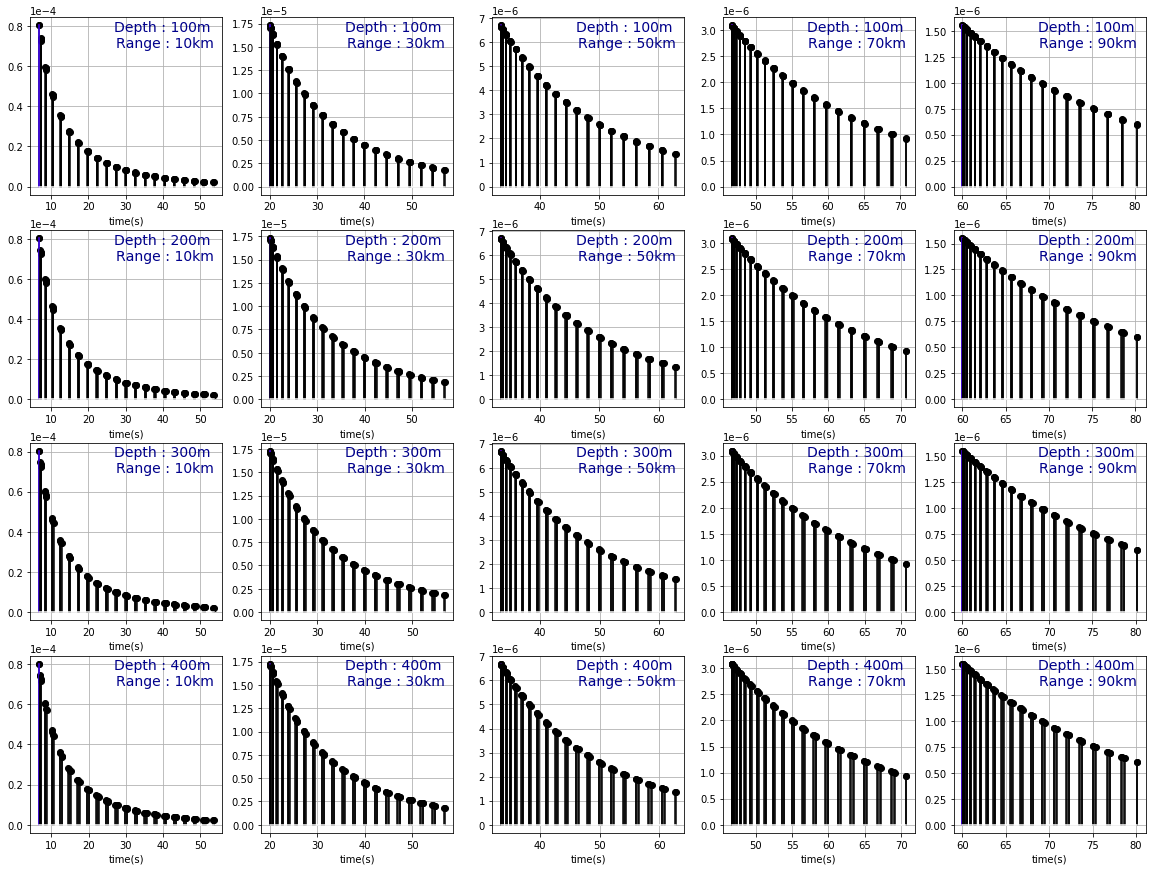

In [5]:
c = 1500.      # célérité (en m/s)
N = 20

TIMES = np.zeros((D.size*R.size, N*4))
AMP   = np.zeros((D.size*R.size, N*4))

plt.figure(figsize=(20,15))
k = 0
for i in range (D.size):
    for j in range(R.size):
        k+=1
        zr = D[i]                   # profondeur du récepteur
        r  = R[j]                   # range du récepteur
        zf = Z - zs - abs(zr - zs)  # profondeur entre récepteur et fond

        ###### Calcul de la réponse impulsionnelle
        Dist = []
        for n in range (N) : 
            ray1 = (2*n+1)*Z - zf - zs
            ray2 = (2*n+1)*Z - zf + zs
            ray3 = (2*n+1)*Z + zf - zs
            ray4 = (2*n+1)*Z + zf + zs
            Rays = [ray1, ray2, ray3, ray4]

            for m in range (len(Rays)):
                teta = np.arctan (Rays[m]/r)
                dist = r/np.cos(teta)
                Dist.append(dist)
                
        Dist = np.array(Dist)
        Times = Dist / c
        TIMES[k-1,:] = Times
        
        ##### Calcul des amplitudes
        alpha = 0.19 /1000.    # en dB/m
        TL = 20*np.log10(Dist) + alpha * Dist
        A = 10**(-TL/20.) 
        AMP[k-1,:] = A
        
        ##### Plot 
        ax = plt.subplot(D.size,R.size,k)
        markerline, stemlines, baseline = plt.stem(Times, A)
        plt.setp(stemlines, color = 'k')
        plt.setp(stemlines[0], color = 'r')
        plt.setp(stemlines[1], color = 'b')
        plt.setp(markerline, color = 'k')
        plt.setp(baseline, color='w')
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(zr,r/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.xlabel('time(s)')
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.grid()

plt.show()    

### --->   Zoom sur les 1ères arrivées

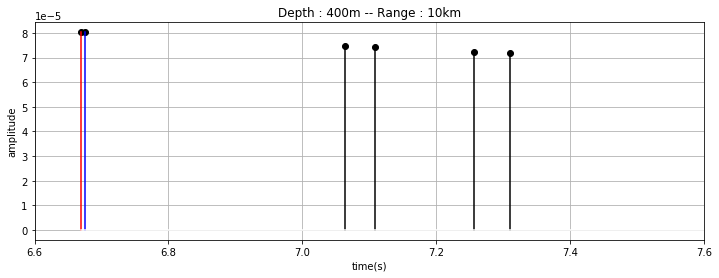

In [6]:
dep = 400.         # depth (m)    
ran = 10.          # range (km)   

### Indices correspondants
idx_d = np.where(D==dep)[0][0]
idx_r = np.where(R==ran*1000.)[0][0]
k = R.size*idx_d + idx_r

### Plot   
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
markerline, stemlines, baseline = plt.stem(TIMES[k,:], AMP[k,:])
plt.setp(stemlines, color = 'k')
plt.setp(stemlines[0], color = 'r')
plt.setp(stemlines[1], color = 'b')
plt.setp(markerline, color = 'k')
plt.setp(baseline, color='w')
plt.title('Depth : %dm -- Range : %.dkm' %(dep,ran))
plt.xlabel('time(s)')
plt.ylabel('amplitude')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
plt.grid()

plt.xlim([6.6,7.6])
plt.show()

---
---
## B - Résultats BELLHOP

In [7]:
### read file .arr 
Arr, Pos = bell.read_arrivals_asc ('files_arr/isocel.arr', Narrmx = 45)

Max.number of arrivals for source index 0 is 42


In [8]:
### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos['r']['range']==R[i])[0][0]

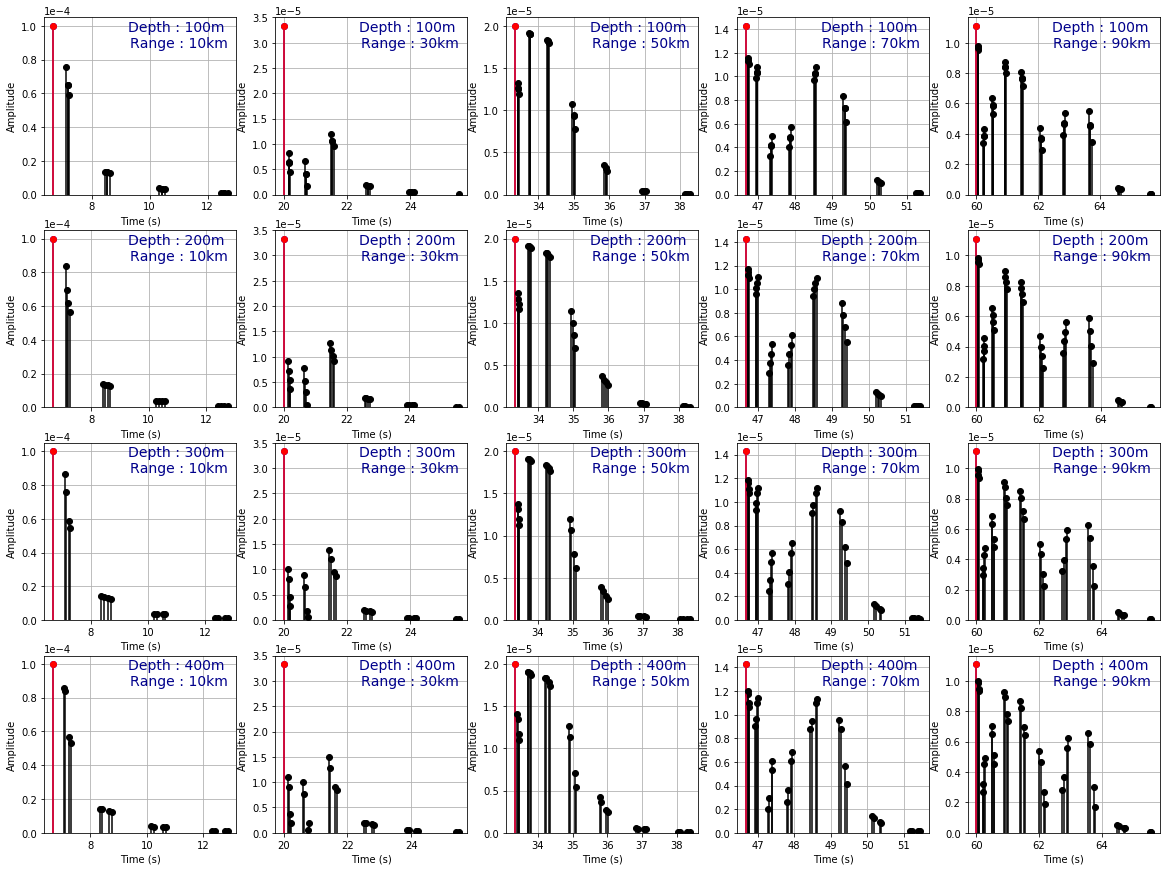

In [9]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        bell.plotarr(Arr, Pos, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr['Narr'][irr,ird,isd])
        amp = Arr['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

---
###  ---> Zoom sur les premières arrivées

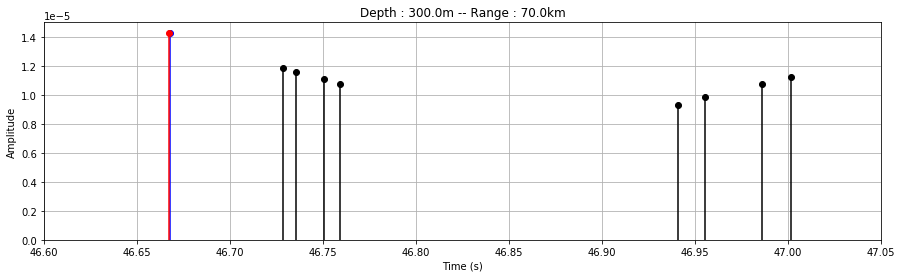

In [10]:
ird = 3       # depth : 300m    
irr = 7       # range : 50km   

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
bell.plotarr(Arr, Pos, irr, ird, isd)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
plt.xlim([46.6, 47.05])
plt.grid()
plt.show()

#### Point positif : mêmes temps d'arrivée

In [11]:
### si on prend 300m et 70km
dep = 300.         # depth (m)    
ran = 70.          # range (km)   

### temps d'arrivée Bellhop
ird = int(dep/100.)
irr = int(ran/10.)
Narr = int(Arr['Narr'][irr,ird,isd])
time_bellhop = sorted(Arr['delay'][irr, :Narr, ird, isd])

### temps d'arrivée calculs python
idx_d = np.where(D==dep)[0][0]
idx_r = np.where(R==ran*1000.)[0][0]
k = R.size*idx_d + idx_r
time_python  = TIMES[k,:Narr]

### différences de temps d'arrivée
dt = abs(time_bellhop - time_python)
print("La différence de temps maximale observée entre les 2 méthodes est de : %.2e s." %(np.max(dt)))

La différence de temps maximale observée entre les 2 méthodes est de : 5.76e-06 s.


---
#### Point négatif : Etalement temporel total trop court

 - On devrait obtenir :    $ dt = T_{last} - T_{first} =  \frac{R . cos(60°) - R}{1500} $  , avec R le range. 

In [12]:
n = R.size
print('Etalement temporel total : \n')
print ('                   10km      30km      50km      70km      90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %.2fs     %.2fs     %.2fs     %.2fs     %.2fs' %(D[i], Total_time[n*i], \
                                                                        Total_time[n*i+1], Total_time[n*i+2], \
                                                                        Total_time[n*i+3], Total_time[n*i+4]))
print('\n  Théorie :        %.2fs     %.2fs    %.2fs    %.2fs    %.2fs' %(R[0]/c, R[1]/c, R[2]/c, R[3]/c,R[4]/c))

Etalement temporel total : 

                   10km      30km      50km      70km      90km

  Depth = 100m :   6.03s     5.53s     4.94s     4.70s     5.66s
  Depth = 200m :   6.08s     5.57s     4.97s     4.73s     5.63s
  Depth = 300m :   6.14s     5.53s     5.00s     4.76s     5.60s
  Depth = 400m :   6.19s     5.49s     5.03s     4.78s     5.58s

  Théorie :        6.67s     20.00s    33.33s    46.67s    60.00s


---
#### Y a-t-il un seuil d'amplitude minimale en dessous duquel on ne prend plus en compte les arrivées ? 

In [13]:
print("Amplitude minimum : \n")
print ('                    10km          30km         50km         70km         90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %.2e     %.2e     %.2e     %.2e     %.2e' %(D[i], Amp_min[n*i], \
                                                                        Amp_min[n*i+1], Amp_min[n*i+2], \
                                                                        Amp_min[n*i+3], Amp_min[n*i+4]))

Amplitude minimum : 

                    10km          30km         50km         70km         90km

  Depth = 100m :   1.02e-06     1.32e-07     9.94e-08     1.36e-07     5.07e-08
  Depth = 200m :   1.01e-06     1.31e-07     9.79e-08     1.32e-07     5.24e-08
  Depth = 300m :   1.01e-06     1.32e-07     9.63e-08     1.28e-07     5.41e-08
  Depth = 400m :   1.00e-06     1.33e-07     9.48e-08     1.25e-07     5.59e-08


---
---
## C - Réflexion parfaite


- Réflexion "parfaite" obtenur en augmentant très fortement la densité du fond. (Il doit exister une méthode plus propre...)

- Permet la comparaison avec les résultats Python. 

- Obtient-t-on le bon étalement temporel ? 

Max.number of arrivals for source index 0 is 174


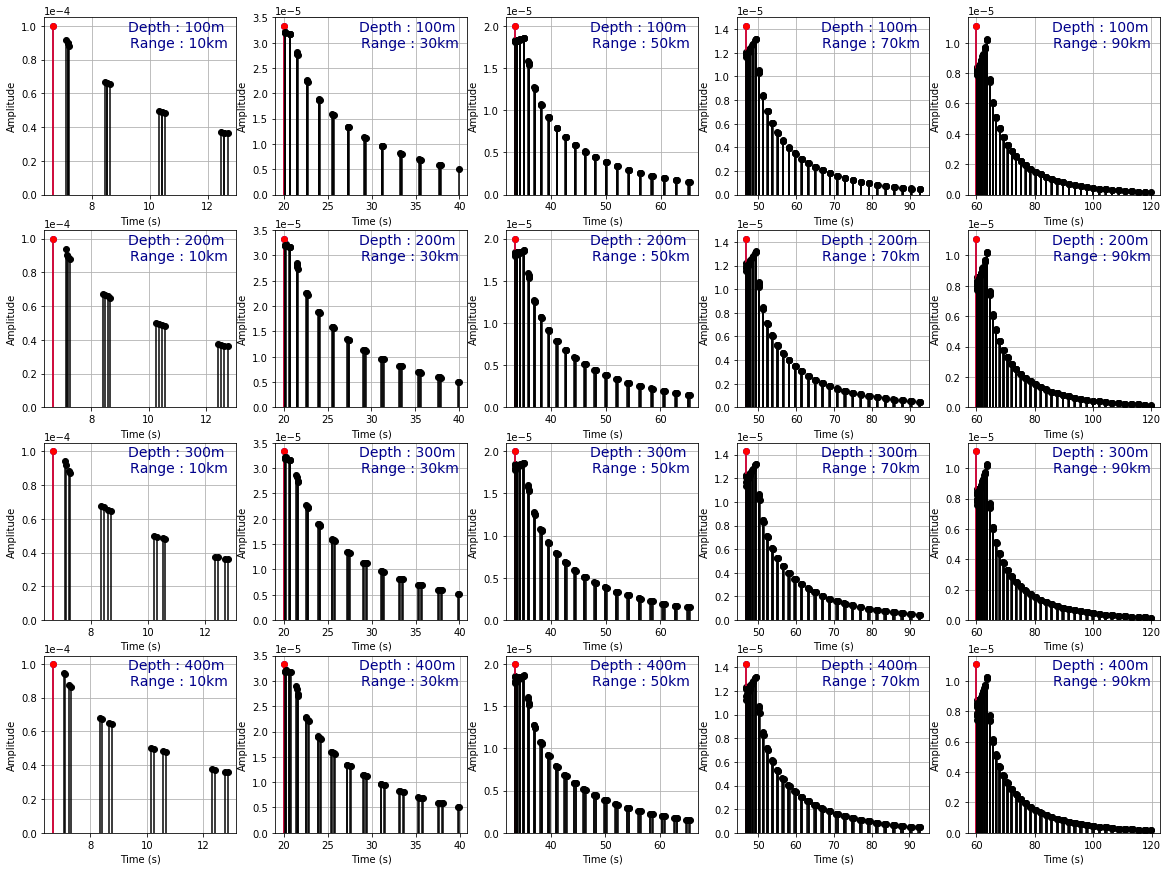

In [14]:
Arr1, Pos1 = bell.read_arrivals_asc ('files_arr/isocel_parfait.arr', Narrmx = 180)

Total_time = []
Dt_first = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        bell.plotarr(Arr1, Pos1, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr1['Narr'][irr,ird,isd])
        times = Arr1['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))
        sort = sorted(times)
        Dt_first.append(sort[1] - sort[0])

---
### ---> Zoom sur les 1ères arrivées

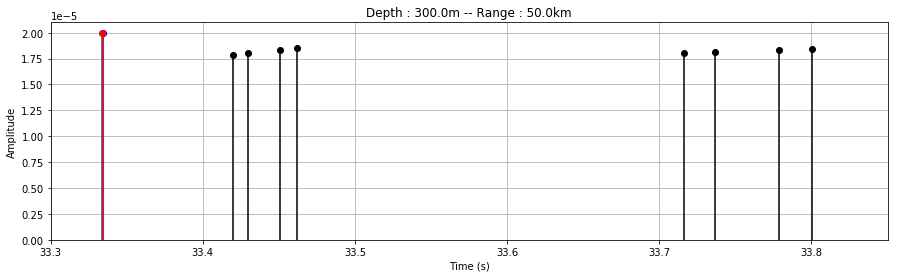

In [15]:
ird = 3       # depth : 300m    
irr = 5       # range : 50km   

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
bell.plotarr(Arr1, Pos1, irr, ird, isd)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
plt.xlim([33.3, 33.85])
plt.grid()
plt.show()

- 2 premiers rayons : Rayon direct + rayon réfléchi sur la surface.
- Ensuite : On a bien des paquets de 4 rayons. 

#### Cette fois-ci, l'étalement temporel est correct : 

In [16]:
n = R.size
print('Etalement temporel total : \n')
print ('                   10km      30km      50km      70km      90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %.2fs     %.2fs     %.2fs     %.2fs     %.2fs' %(D[i], Total_time[n*i], \
                                                                        Total_time[n*i+1], Total_time[n*i+2], \
                                                                        Total_time[n*i+3], Total_time[n*i+4]))

Etalement temporel total : 

                   10km      30km      50km      70km      90km

  Depth = 100m :   6.03s     19.91s     31.95s     46.06s     59.95s
  Depth = 200m :   6.08s     19.96s     32.01s     46.12s     60.01s
  Depth = 300m :   6.14s     19.91s     32.07s     46.18s     59.95s
  Depth = 400m :   6.19s     19.85s     32.12s     46.24s     59.89s


---
---
# II - Profil Méditerrannée hiver

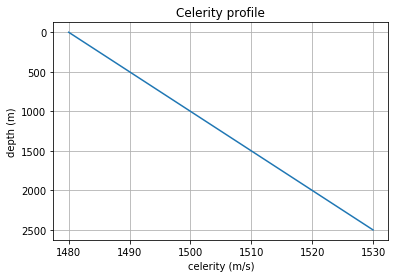

In [17]:
cmin = 1480.
cmax = 1530.
Zmax = 2500.

zz = np.linspace(0,Zmax,51)
cel = np.linspace (cmin, cmax, 51)
plt.plot(cel, zz)
plt.title ('Celerity profile')
plt.xlabel('celerity (m/s)')
plt.ylabel('depth (m)')
plt.gca().invert_yaxis()
plt.grid()

In [18]:
### read file .arr 
Arr2, Pos2 = bell.read_arrivals_asc ('files_arr/prof_hiver_parfait.arr', Narrmx = 205)

Max.number of arrivals for source index 0 is 204


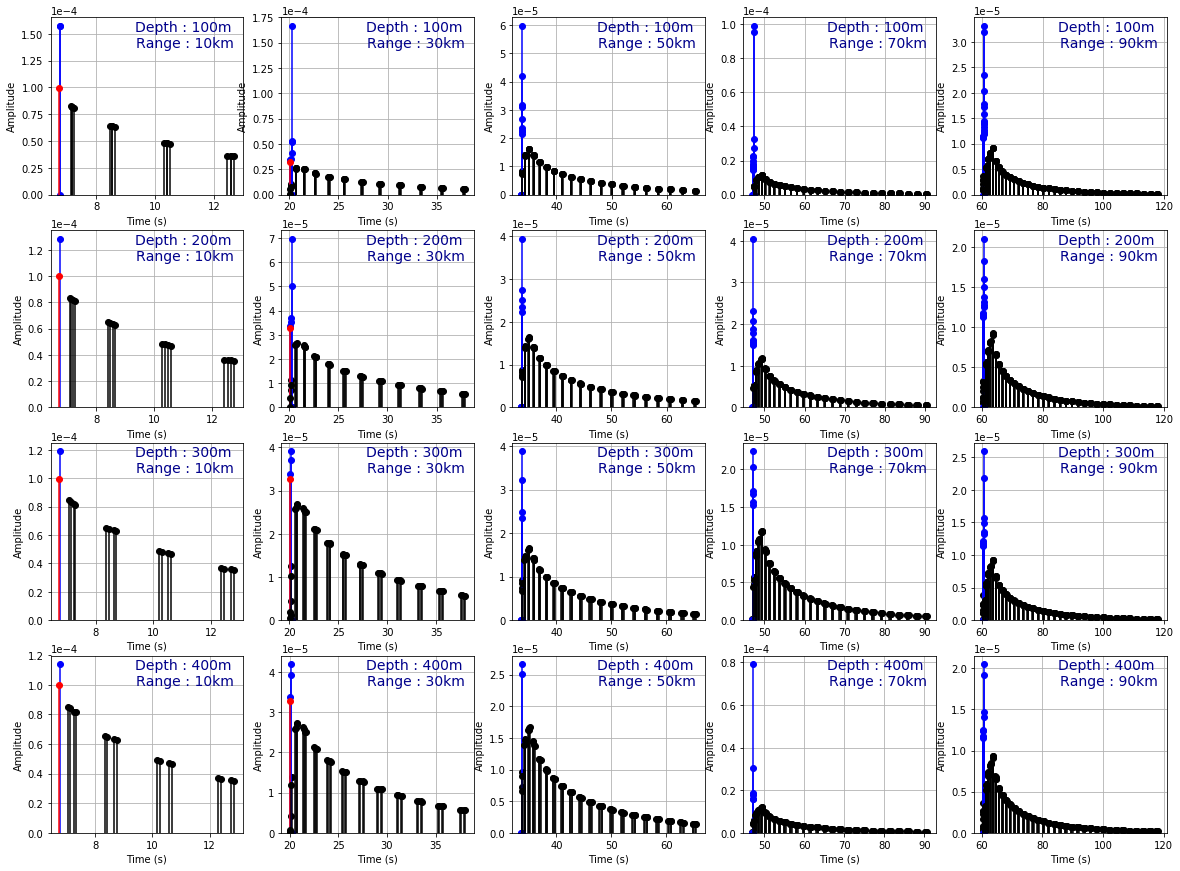

In [19]:
Total_time2 = []
Etal = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        bell.plotarr(Arr2, Pos2, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()

        Narr = int(Arr2['Narr'][irr,ird,isd])
        times = Arr2['delay'][irr, :Narr, ird, isd]
        Total_time2.append(np.max(times)-np.min(times))
        sort = sorted(times)
        amp = Arr2['A'][irr,:Narr, ird, isd]
        t_amp_max = times[np.where(abs(amp) == np.max(abs(amp)))[0]]
        eta = t_amp_max - sort[0]
        Etal.append(eta)

----
### ---> Zoom sur les premières arrivées

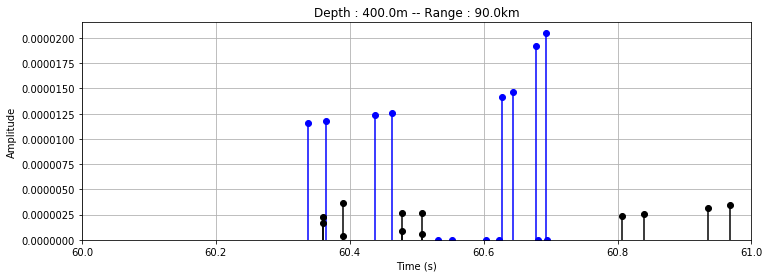

In [20]:
isd = 0       # choice of source depth : 100m
ird = 4       # depth : 400m    
irr = 9       # range : 90km   
plt.figure(figsize=(12,4))
bell.plotarr(Arr2, Pos2, irr, ird, isd)
plt.xlim([60., 61.])
plt.grid()
plt.show()

---
### Quel lien entre range et étalement des rayons réfractés (bleus) ?

- Différence de temps d'arrivée entre la 1ère arrivée et le max d'amplitude

In [21]:
### Reponses impulsionnelles
Dd = np.array([100., 200., 300., 400.])
Rr = np.array([10., 20., 30., 40., 50., 60., 70., 80., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', Dd.size * Rr.size)

### Indices correspondants
IRDt = np.zeros_like(Dd)
for i in range (Dd.size) : 
    IRDt[i] = np.where(Pos2['r']['depth']==Dd[i])[0][0]
    
IRRt = np.zeros_like(Rr)
for i in range (Rr.size) : 
    IRRt[i] = np.where(Pos2['r']['range']==Rr[i])[0][0]

Nombre total de réponses impulsionnelles :  36


In [22]:
Etalt = []
for i in range (IRDt.size):
    for j in range(IRRt.size):
        
        ird = int(IRDt[i])     # choice of receiver depth
        irr = int(IRRt[j])     # choice of receiver range
        Narr = int(Arr2['Narr'][irr,ird,isd])
        times = Arr2['delay'][irr, :Narr, ird, isd]
        sort = sorted(times) 
        amp = Arr2['A'][irr,:Narr, ird, isd]
        t_amp_max = times[np.where(abs(amp) == np.max(abs(amp)))[0]]
        eta = t_amp_max - sort[0]
        Etalt.append(eta)

In [23]:
nn = Rr.size
print('Etalement temporel rayons réfractés : \n')
print ('                   10km      20km      30km      40km      50km      60km     70km      80km    90km\n')
for i in range(Dd.size) :  
    print('  Depth = %dm :   %.2fs     %.2fs     %.2fs     %.2fs    %.2fs     %.2fs    %.2fs     %.2fs    %.2fs' %(D[i],\
                                                            Etalt[nn*i], Etalt[nn*i+1], Etalt[nn*i+2], \
                                                            Etalt[nn*i+3], Etalt[nn*i+4], Etalt[nn*i+5], \
                                                            Etalt[nn*i+6], Etalt[nn*i+7], Etalt[nn*i+8]))

Etalement temporel rayons réfractés : 

                   10km      20km      30km      40km      50km      60km     70km      80km    90km

  Depth = 100m :   0.01s     0.05s     0.15s     0.09s    0.16s     0.28s    0.38s     0.29s    0.40s
  Depth = 200m :   0.01s     0.05s     0.16s     0.09s    0.16s     0.27s    0.34s     0.27s    0.39s
  Depth = 300m :   0.01s     0.06s     0.10s     0.07s    0.15s     0.26s    0.32s     0.25s    0.38s
  Depth = 400m :   0.01s     0.02s     0.13s     0.08s    0.12s     0.25s    0.31s     0.23s    0.36s


---
---
# Etude du 3ème profil 

- Minimum de célérité situé à 100m de profondeur.

- Deux études : source placée à 50m de profondeur, puis à 150m.

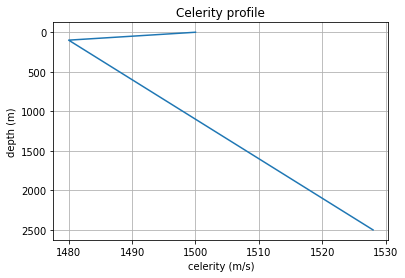

In [24]:
c1 = np.array([1500.,1490.,1480.])
c2 = np.linspace(1481,1528,48)
cel2 = np.hstack((c1,c2)) 
plt.plot(cel2, zz)
plt.title ('Celerity profile')
plt.xlabel('celerity (m/s)')
plt.ylabel('depth (m)')
plt.gca().invert_yaxis()
plt.grid()

### A -  Source à 50m

In [25]:
### read file .arr 
Arr4, Pos4 = bell.read_arrivals_asc ('files_arr/prof3_parfait_s50.arr', Narrmx = 600)

Max.number of arrivals for source index 0 is 502


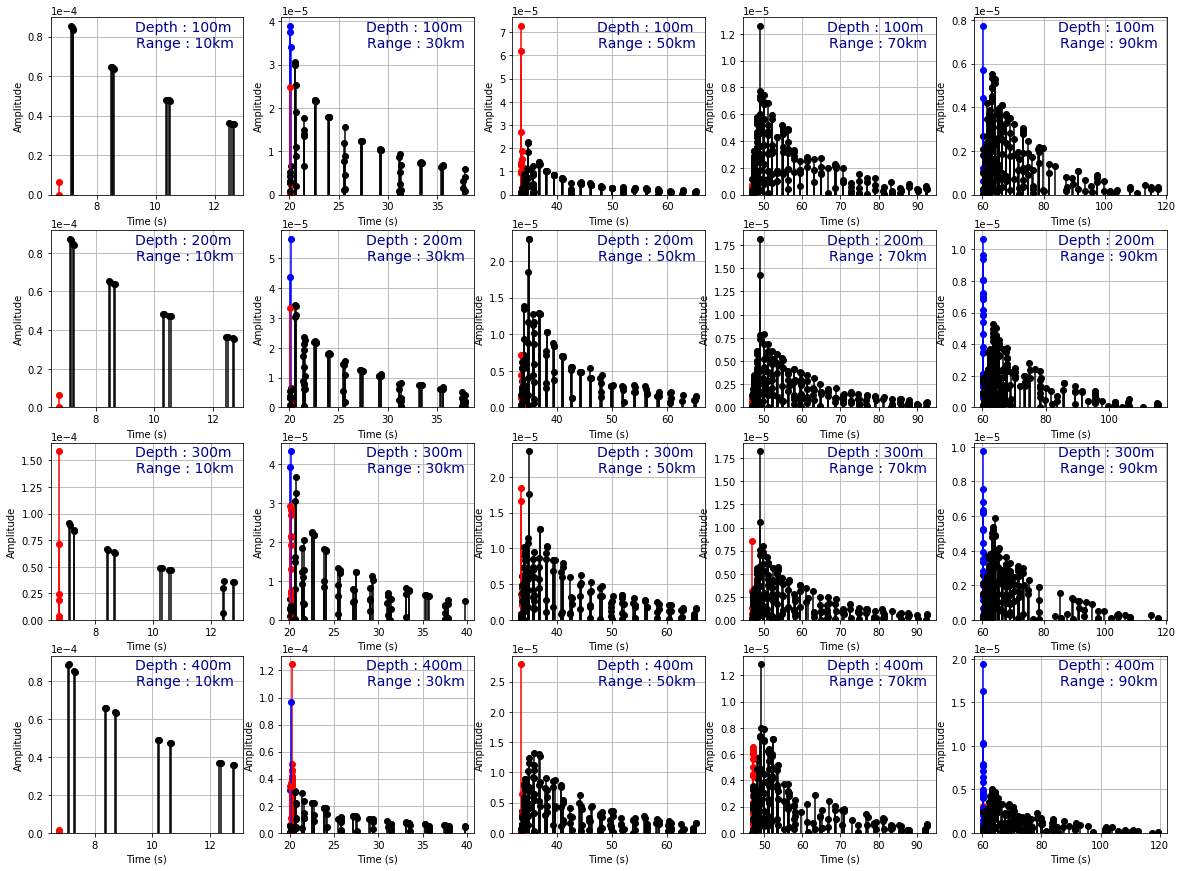

In [27]:
plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        bell.plotarr(Arr4, Pos4, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()              

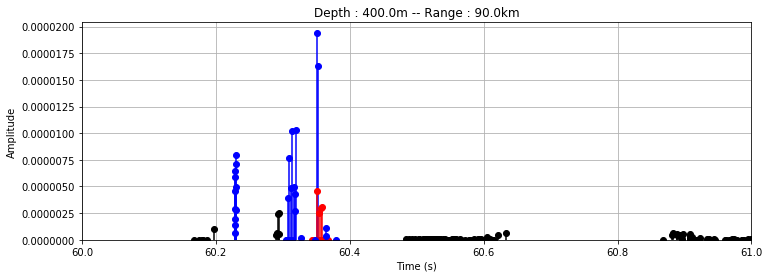

In [28]:
ird = 4       # depth : 400m    
irr = 9       # range : 90km   
plt.figure(figsize=(12,4))
bell.plotarr(Arr4, Pos4, irr, ird, isd)
plt.xlim([60., 61.])
plt.grid()
plt.show()

---
### B - Source à 150m

In [29]:
### read file .arr 
Arr3, Pos3 = bell.read_arrivals_asc ('files_arr/prof3_parfait.arr', Narrmx = 600)

Max.number of arrivals for source index 0 is 561


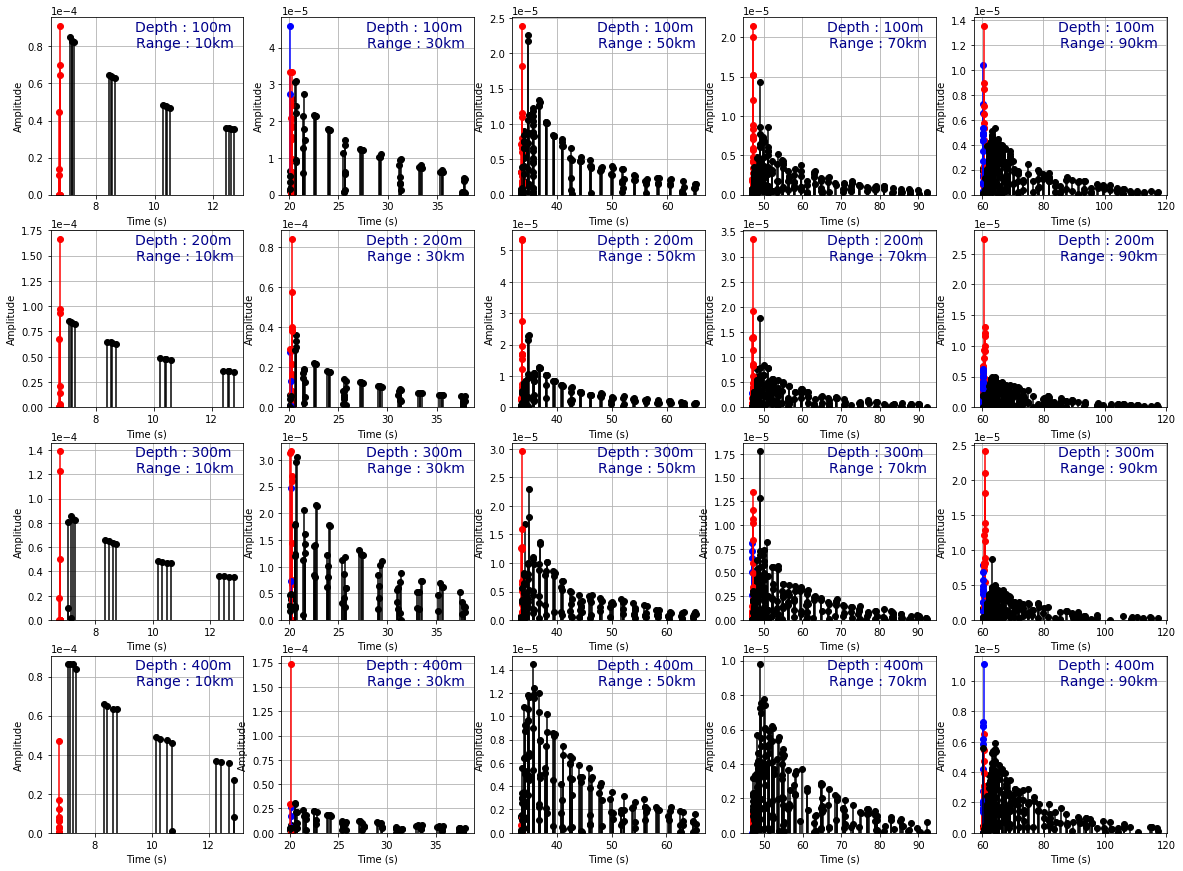

In [30]:
plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        bell.plotarr(Arr3, Pos3, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()

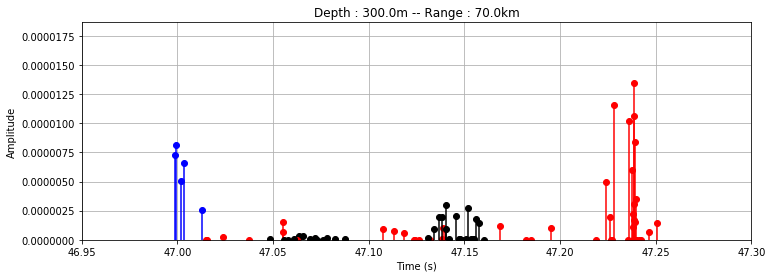

In [35]:
ird = 3       # depth : 400m    
irr = 7       # range : 90km   
plt.figure(figsize=(12,4))
bell.plotarr(Arr3, Pos3, irr, ird, isd)
plt.xlim([46.95, 47.3])
plt.grid()
plt.show()

---
---
---
---
---
---
---
---
---
---
----
---
---
-----
---
---
---
---
---
---

# Annexe : Profil hiver réel sans réflexion parfaite

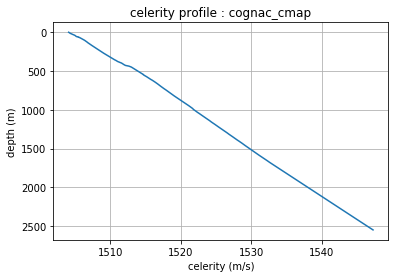

In [36]:
bell.plotssp('mediterrannee', Issp=1, zoom=False)

In [37]:
### read file .arr 
Arr5, Pos5 = bell.read_arrivals_asc ('files_arr/prof_hiver.arr', Narrmx = 340)

Max.number of arrivals for source index 0 is 339


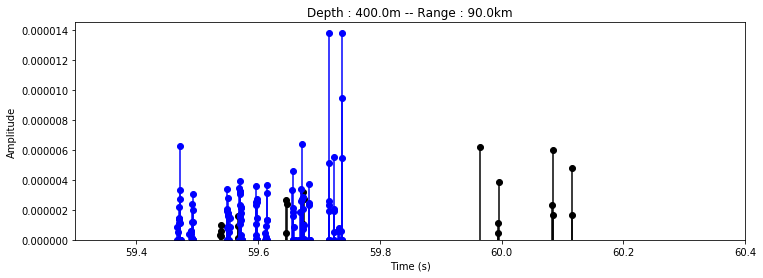

In [38]:
isd = 0       # choice of source depth : 100m
ird = 4       # depth : 400m    
irr = 9       # range : 90km   
plt.figure(figsize=(12,4))
bell.plotarr(Arr5, Pos5, irr, ird, isd)
plt.xlim([59.3, 60.4])
plt.show()